# Salmon CRAC-seq: Test effect of index k-mer size on results

**WARNING**: This is a pretty technical analysis. Basically I was trying to evaluate the effect of Salmon k-mer index size on quantification of CRAC-seq data. This led me to investigate sources of clear misquantifications (e.g. >0 quantification of neochr pre-tRNAs in absense of neochr)

I will try to explain each piece of data/figure when it comes up.

**Bottom line**
- Small k-mers are problematic. 
- k-mer size of 15 seems to work reasonably well
- k-mer size effect on quantification is small regardless
- Misquantifications seem to arise from high equivalence class overlap (neo chr pre-tRNAs in many equivalence classes with pre-tRNAs from chr)

<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>

In [1]:
options(warn=-1)
#options(warn=0)
.libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
# config opts and libraries
options(repr.plot.width = 6, repr.plot.height = 5)
options(jupyter.plot_mimetypes = 'image/png')
suppressMessages(devtools::source_url("https://raw.githubusercontent.com/scalefreegan/R-tools/master/defaultRlibs.R"))
suppressMessages(devtools::source_url("https://raw.githubusercontent.com/scalefreegan/steinmetz-lab/master/yeast2_0/scripts/salmontools.R"))
suppressMessages({
    library(forcats)
    library(wasabi)
    library(data.table)
    library(dtplyr)
})

In [2]:
# load ncRNA annotations
load("/g/steinmetz/project/IESY/trna/data/ncRNA_annotations.rda")

In [3]:
sample2ezname = function(x) {
    o = x
    o[x == "S1"] = "BY4741-neg"
    o[x == "S2"] = "BY4741"
    o[x == "S3"] = "BY4741+neo"
    return(o)
}
chr2ezname = function(x) {
    o = x
    o[x == "chr17"] = "mito"
    o[x == "chr18"] = "neo"
    return(o)
}
RESULTS = "/g/steinmetz/project/IESY/trna/results/polIIIcrac"

suppressMessages({
S2_15 = read_tsv(file.path(RESULTS, "04_TT16612_BY_Rpc160HTP_wt_comp_17bp/quant.sf"), col_names = T) %>% 
    mutate(sample = "S2", kmer = 15) %>% mutate(ezsample = sample2ezname(sample))
S3_15 = read_tsv(file.path(RESULTS, "04_TT16612_BY_Rpc160HTP_Neo_comp_17bp/quant.sf"), col_names = T) %>% 
    mutate(sample = "S3", kmer = 15) %>% mutate(ezsample = sample2ezname(sample))
S2_3 = read_tsv(file.path(RESULTS, "kmer_test/wt_3/quant.sf"), col_names = T) %>% 
    mutate(sample = "S2", kmer = 3) %>% mutate(ezsample = sample2ezname(sample))
S3_3 = read_tsv(file.path(RESULTS, "kmer_test/neo_3/quant.sf"), col_names = T) %>% 
    mutate(sample = "S3", kmer = 3) %>% mutate(ezsample = sample2ezname(sample))
S2_7 = read_tsv(file.path(RESULTS, "kmer_test/wt_7/quant.sf"), col_names = T) %>% 
    mutate(sample = "S2", kmer = 7) %>% mutate(ezsample = sample2ezname(sample))
S3_7 = read_tsv(file.path(RESULTS, "kmer_test/neo_7/quant.sf"), col_names = T) %>% 
    mutate(sample = "S3", kmer = 7) %>% mutate(ezsample = sample2ezname(sample))
})

results = bind_rows(S2_15, S3_15, S2_3, S3_3, S2_7, S3_7)
results$Name.original = results$Name
results = results %>% separate(Name, into = c("origin","Name"),sep = "\\.", extra = "merge", remove = T)
# because of naming, I need to move to mtrans
mtrnas = which(is.na(results$Name))
if (length(mtrnas) > 0) {
    results$Name[mtrnas] = results$origin[mtrnas]
    results$origin[mtrnas] = NA
} 
# combine with ncRNA annotations
results = merge(results, allncrnas, by = c("Name","origin"))
results = results %>% separate(Name, into = c("tmp1","tmp2"), sep = "-", extra = "merge", remove = F) %>%
    separate(tmp2, into = c("AA","Isotype"), sep = 3, remove = T) %>%
    separate(Isotype, into = c("Isotype","Isotype.Number"), sep = 3, remove = T) %>%
    mutate(mature.trna = ifelse(grepl("tRNA", Name) & !grepl("chr", Name),T,F))
results = results %>% mutate(ezseqid = chr2ezname(seqid), ezsample = sample2ezname(sample))
results$tmp1 = NULL

# customize annotations
results$type[grepl("tRNA",results$Name)] = "mature_tRNA"
results$type[grepl("chr.*tRNA",results$Name)] = "pre_tRNA"
results$type[grepl("snoRNA_gene",results$type)] = "snoRNA"
results$type[grepl("ncRNA_gene",results$type)] = "ncRNA_other"
results$type[grepl("snRNA_gene",results$type)] = "snRNA"
results$type[grepl("rRNA_gene",results$type)] = "rRNA"
results$ezseqid[which(results$type=="mature_tRNA")] = "mature"
results$type = factor(results$type, levels = (c(
"pre_tRNA",
"mature_tRNA",
"rRNA",
"snoRNA",
"snRNA",
"ncRNA_other")))

In [4]:
# load data from tomek
tf1 = "/g/steinmetz/project/IESY/trna/results/polIIIcrac/tomek_data/trna_crac.txt"
tf2 = "/g/steinmetz/project/IESY/trna/results/polIIIcrac/tomek_data/trna_crac_random.txt"
suppressMessages({
trna_crac = readr::read_delim(tf1, delim = "\t")
colnames(trna_crac)[colnames(trna_crac)=="Rpc160HTP_wt_none"] = "none"
colnames(trna_crac)[colnames(trna_crac)=="04_TT16612_BY4741"] = "wt"
colnames(trna_crac)[colnames(trna_crac)=="Rpc160HTP_Neo_none"] = "neo"
trna_crac_random = readr::read_delim(tf2, delim = "\t")
})

In [5]:
aggresults = acast(results %>% filter(grepl("tRNA",Name)), 
                   formula = Name ~ ezsample + kmer, value.var = "TPM", fun.aggregate = median) 
aggresults = log2(aggresults + 1)
colnames(aggresults) = sample2ezname(colnames(aggresults))

# Figure 1: Comparison of quantification results with different k-mer indexes

**Result**

- Samples w|w/o neochr are most similar to one another independent of k-mer index size
- Hard to determine "optimal" k-mer index length 

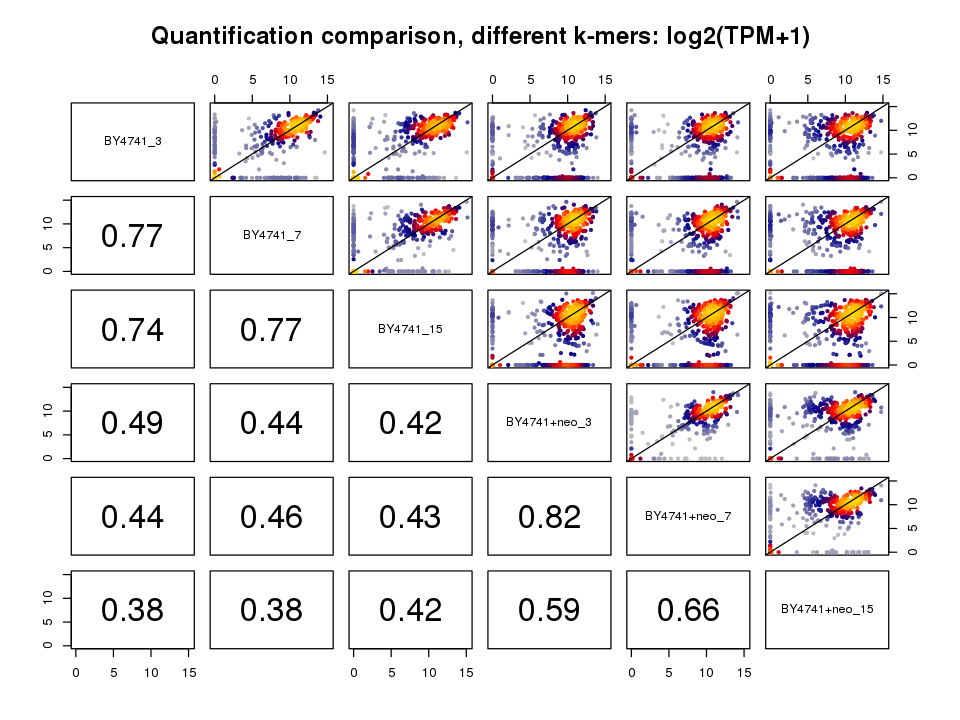

In [6]:
options(repr.plot.width = 8)
options(repr.plot.height = 6)
LSD::heatpairs(aggresults, main = "Quantification comparison, different k-mers: log2(TPM+1)")

# Figure 2: Is misquantification rate variable across k-mer index sizes?

Does the misquantification rate vary across different k-mers?

*Misquantifcation rate* = # neo-chr pre-tRNAs with TPM > 0 in BY4741 / total # of neochr pre-tRNAs

**Result**
- Misquantification rate is lowest at k-mer index size of 15. This supports using longer k-mer index for quantification. Fewer pre-tRNAs clearly misquantified.

**NOTE**
15 is the longest k-mer size for this data. Longest fragments in the dataset are 17nt.

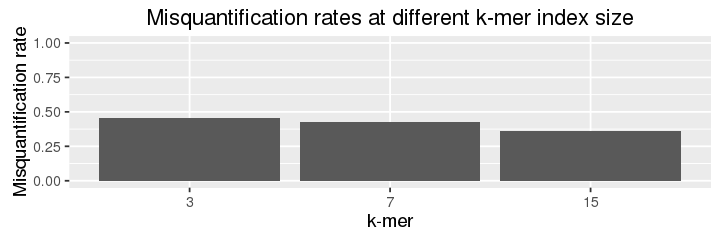

In [7]:
syn.tot = dim(unique(results %>% filter(origin=="SYN",sample=="S2") %>% select(Name)))[1]

misquant = results %>% filter(origin=="SYN",sample=="S2") %>% group_by(sample,kmer) %>%
    summarise(misquant.rate = sum(as.numeric(TPM)>0)/syn.tot)

options(repr.plot.width = 6, repr.plot.height = 2)
p2 <- ggplot(misquant, aes(x=factor(kmer), y=misquant.rate)) + geom_bar(stat="identity") + 
    ylim(c(0,1)) + ylab("Misquantification rate") + xlab("k-mer") + 
    ggtitle("Misquantification rates at different k-mer index size")
p2

## Access bootstraps

In [8]:
salmondirs <- file.path(RESULTS, c("04_TT16612_BY_Rpc160HTP_wt_comp_17bp",
                                   "04_TT16612_BY_Rpc160HTP_Neo_comp_17bp",
                                   "kmer_test/wt_3",
                                   "kmer_test/neo_3",
                                   "kmer_test/wt_7",
                                   "kmer_test/neo_7"))
for (i in salmondirs) {
    if (file.exists(file.path(i,"abundance.h5"))) {
        file.remove(file.path(i,"abundance.h5"))
    }
}

suppressMessages({prepare_fish_for_sleuth(salmondirs)})

Thu Nov 10 10:45:49 2016
[1] "Successfully converted sailfish / salmon results in /g/steinmetz/project/IESY/trna/results/polIIIcrac/04_TT16612_BY_Rpc160HTP_wt_comp_17bp to kallisto HDF5 format"
Thu Nov 10 10:45:51 2016
[1] "Successfully converted sailfish / salmon results in /g/steinmetz/project/IESY/trna/results/polIIIcrac/04_TT16612_BY_Rpc160HTP_Neo_comp_17bp to kallisto HDF5 format"
Thu Nov 10 10:45:53 2016
[1] "Successfully converted sailfish / salmon results in /g/steinmetz/project/IESY/trna/results/polIIIcrac/kmer_test/wt_3 to kallisto HDF5 format"
Thu Nov 10 10:45:55 2016
[1] "Successfully converted sailfish / salmon results in /g/steinmetz/project/IESY/trna/results/polIIIcrac/kmer_test/neo_3 to kallisto HDF5 format"
Thu Nov 10 10:45:57 2016
[1] "Successfully converted sailfish / salmon results in /g/steinmetz/project/IESY/trna/results/polIIIcrac/kmer_test/wt_7 to kallisto HDF5 format"
Thu Nov 10 10:45:59 2016
[1] "Successfully converted sailfish / salmon results in /g/steinmetz

[1] TRUE

In [9]:
S2_15 = processSalmonH5(file.path(RESULTS, "04_TT16612_BY_Rpc160HTP_wt_comp_17bp/abundance.h5")) %>%  
    mutate(sample = "S2", kmer = 15) %>% mutate(ezsample = sample2ezname(sample))
S3_15 = processSalmonH5(file.path(RESULTS, "04_TT16612_BY_Rpc160HTP_Neo_comp_17bp/abundance.h5")) %>%  
    mutate(sample = "S3", kmer = 15) %>% mutate(ezsample = sample2ezname(sample))
S2_3 = processSalmonH5(file.path(RESULTS, "kmer_test/wt_3/abundance.h5")) %>% 
    mutate(sample = "S2", kmer = 3) %>% mutate(ezsample = sample2ezname(sample))
S3_3 = processSalmonH5(file.path(RESULTS, "kmer_test/neo_3/abundance.h5")) %>% 
    mutate(sample = "S3", kmer = 3) %>% mutate(ezsample = sample2ezname(sample))
S2_7 = processSalmonH5(file.path(RESULTS, "kmer_test/wt_7/abundance.h5")) %>% 
    mutate(sample = "S2", kmer = 7) %>% mutate(ezsample = sample2ezname(sample))
S3_7 = processSalmonH5(file.path(RESULTS, "kmer_test/neo_7/abundance.h5")) %>% 
    mutate(sample = "S3", kmer = 7) %>% mutate(ezsample = sample2ezname(sample))

bs = rbind(S2_15, S3_15, S2_3, S3_3, S2_7, S3_7) %>% 
    mutate_at(.cols = vars(contains("bs")),funs(as.numeric)) %>% 
    group_by(id,est,sample,kmer) %>% do({
        inds = grepl("bs", names(.))
        thismean = mean(as.numeric(.[inds]))
        thissd = sd(as.numeric(.[inds]))
        o = data.frame(id = .$id,
                      est = .$est,
                      mean = thismean,
                      rsd = abs(thissd/(thismean+1e-6)))
        return(o)
    })
bs_dt = dcast(setDT(bs), id + kmer ~ sample, value.var = c("est","rsd")) %>% 
    rowwise() %>% mutate(rsd = max(rsd_S2,rsd_S3))

# Figure 3: Does misuquantification coincide with quantification uncertainty?

**Results**
- Greatest uncertainty is for pre-tRNAs with 0 quantification in one of the samples (one the axes). This is not surprising.

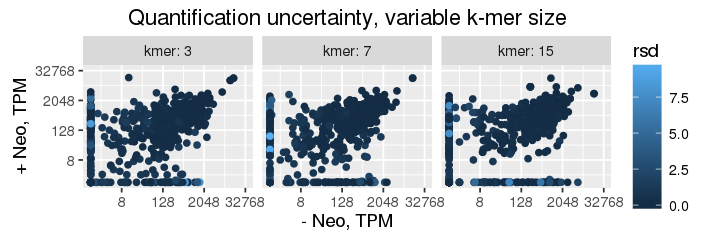

In [10]:
options(repr.plot.width = 6)
options(repr.plot.height = 2)
p3 <- ggplot(bs_dt, aes(x = est_S2+1, y = est_S3+1, color = rsd)) +
    geom_point() + 
    scale_y_continuous(trans="log2", limits = c(1,32768)) + 
    scale_x_continuous(trans="log2", limits = c(1,32768)) +
    facet_grid(~ kmer, labeller = label_both) +
    xlab("- Neo, TPM") +
    ylab("+ Neo, TPM") +
    ggtitle("Quantification uncertainty, variable k-mer size")
p3

# Analyze equivalence classes

In [11]:
suppressMessages({
eq_S2_15 = processEQ(file.path(RESULTS, "04_TT16612_BY_Rpc160HTP_wt_comp_17bp/aux_info/eq_classes.txt")) %>% 
    mutate(sample = "S2", kmer = 15) %>% mutate(ezsample = sample2ezname(sample))
eq_S3_15 = processEQ(file.path(RESULTS, "04_TT16612_BY_Rpc160HTP_Neo_comp_17bp/aux_info/eq_classes.txt")) %>% 
    mutate(sample = "S3", kmer = 15) %>% mutate(ezsample = sample2ezname(sample))
eq_S2_3 = processEQ(file.path(RESULTS, "kmer_test/wt_3/aux_info/eq_classes.txt")) %>% 
    mutate(sample = "S2", kmer = 3) %>% mutate(ezsample = sample2ezname(sample))
eq_S3_3 = processEQ(file.path(RESULTS, "kmer_test/neo_3/aux_info/eq_classes.txt")) %>% 
    mutate(sample = "S3", kmer = 3) %>% mutate(ezsample = sample2ezname(sample))
eq_S2_7 = processEQ(file.path(RESULTS, "kmer_test/wt_7/aux_info/eq_classes.txt")) %>% 
    mutate(sample = "S2", kmer = 7) %>% mutate(ezsample = sample2ezname(sample))
eq_S3_7 = processEQ(file.path(RESULTS, "kmer_test/neo_7/aux_info/eq_classes.txt")) %>% 
    mutate(sample = "S3", kmer = 7) %>% mutate(ezsample = sample2ezname(sample))
})

eq_results = bind_rows(eq_S2_15, eq_S3_15, eq_S2_3, eq_S3_3, eq_S2_7, eq_S3_7)
eq_results = eq_results %>% mutate(neo = grepl("SYN", txs))

tx2eq_S2_15 = tx2eq(eq_S2_15) %>% 
    mutate(sample = "S2", kmer = 15) %>% mutate(ezsample = sample2ezname(sample))
tx2eq_S3_15 = tx2eq(eq_S3_15) %>% 
    mutate(sample = "S3", kmer = 15) %>% mutate(ezsample = sample2ezname(sample))
tx2eq_S2_7 = tx2eq(eq_S2_7) %>% 
    mutate(sample = "S2", kmer = 7) %>% mutate(ezsample = sample2ezname(sample))
tx2eq_S3_7 = tx2eq(eq_S3_7) %>% 
    mutate(sample = "S3", kmer = 7) %>% mutate(ezsample = sample2ezname(sample))
tx2eq_S2_3 = tx2eq(eq_S2_3) %>% 
    mutate(sample = "S2", kmer = 3) %>% mutate(ezsample = sample2ezname(sample))
tx2eq_S3_3 = tx2eq(eq_S3_3) %>% 
    mutate(sample = "S3", kmer = 3) %>% mutate(ezsample = sample2ezname(sample))

tx2eq_results = bind_rows(tx2eq_S2_15, tx2eq_S3_15, tx2eq_S2_3, tx2eq_S3_3, tx2eq_S2_7, tx2eq_S3_7)


Processed file with 684 transcripts in 759 equivalence classes.
Processed file with 684 transcripts in 933 equivalence classes.
Processed file with 684 transcripts in 2136 equivalence classes.
Processed file with 684 transcripts in 2073 equivalence classes.
Processed file with 684 transcripts in 1129 equivalence classes.
Processed file with 684 transcripts in 1232 equivalence classes.


# Figure 4: How reproducible are uniquely mapping equivalence classes across samples?

**Results**
- Quantification of uniquely mapping equivalence classes (i.e. equivalence classes with only one transcript) does not solve the misquantification problem
- There are still misquantifications, even when considering equivalence classes consisting of only a single transcript

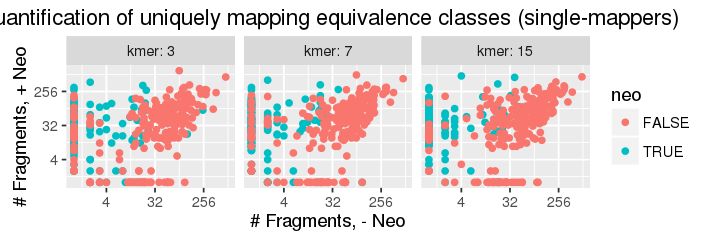

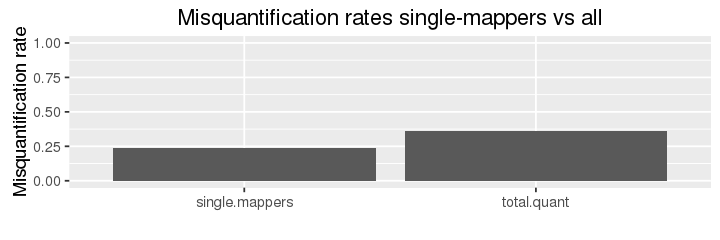

In [12]:
options(repr.plot.width = 8)
options(repr.plot.height = 4)
unique.mappers = dcast(filter(eq_results,tx.per.eq==1,grepl("tRNA",txs)),
            formula = txs+kmer~sample,value.var = "frag.per.eq") %>% 
            mutate(neo = grepl("SYN",txs))
unique.mappers[is.na(unique.mappers)] = 0
p4 <- ggplot(unique.mappers,aes(x=as.numeric(S2)+1,y=as.numeric(S3)+1,color=neo)) + geom_point() +
    scale_y_continuous(trans="log2") + 
    scale_x_continuous(trans="log2") +
    ylab("# Fragments, + Neo") + xlab("# Fragments, - Neo") +
    facet_wrap(~ kmer, labeller = label_both) +
    ggtitle("Quantification of uniquely mapping equivalence classes (single-mappers)")


syn.tot = dim(unique(results %>% filter(origin=="SYN",sample=="S2") %>% select(Name)))[1]

misquant15 = results %>% filter(origin=="SYN",sample=="S2", kmer==15) %>% group_by(sample,kmer) %>%
    summarise(misquant.rate = sum(as.numeric(TPM)>0)/syn.tot)

misquant.compare = rbind(filter(unique.mappers, kmer==15, grepl("SYN",txs)) %>% 
                         summarise(type="single.mappers",misquant.rate = sum(S2>0)/syn.tot),
                         data.frame(type="total.quant",misquant.rate = misquant15$misquant.rate))

options(repr.plot.width = 6, repr.plot.height = 2)
p5 <- ggplot(misquant.compare, aes(x=factor(type), y=misquant.rate)) + geom_bar(stat="identity") + 
    ylim(c(0,1)) + ylab("Misquantification rate") + xlab("") + 
    ggtitle("Misquantification rates single-mappers vs all")
p4
p5

# Figure 5: How many equivalence classes do transcripts map to?

**Result**
- Most tRNAs are in more than one equivalence class
- Smaller kmer values lead to more equivalence classes per transcript
    - I think this is a problem. Better to have larger k-mer size, e.g. 15

,tx,eqs,neqs,sample,kmer,ezsample
1,WT.chr10.tRNA10-ArgCCT,1 410 600,3,S2,15,BY4741
2,SYN.chr18.tRNA182-ThrAGT,2 24 126 707,4,S2,15,BY4741
3,WT.chr07.tRNA31-ValAAC,3 124 482 730,4,S2,15,BY4741
4,SYN.chr18.tRNA104-IleAAT,4 19 32 324 365 414 671 727 748,9,S2,15,BY4741
5,SYN.chr18.tRNA140-IleAAT,4 19 32 65 748,5,S2,15,BY4741
6,SYN.chr18.tRNA101-ArgACG,5 61 350 380 676,5,S2,15,BY4741


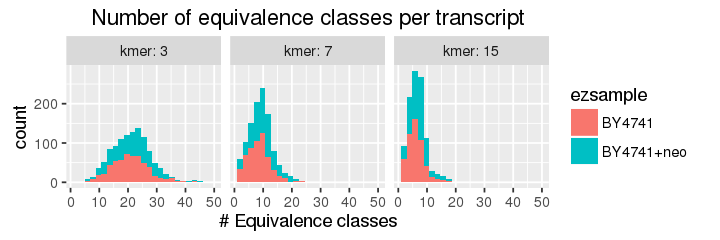

In [13]:
head(tx2eq_results)
p5 <- ggplot(filter(tx2eq_results,grepl("tRNA",tx)), aes(neqs,fill=ezsample)) + 
    geom_histogram(bins=25) + facet_wrap(~ kmer, labeller = label_both) +
    #scale_x_continuous(trans="log2") +
    ggtitle("Number of equivalence classes per transcript") +
    xlab("# Equivalence classes")
p5

# An example of mapping uniqueness problem, chr18.tRNA104-IleAAT

chr18.tRNA104-IleAAT is misquantified in the BY4741 sample. TPM should be zero, instead it is 20.8. This is 1.7-fold lower than in the BY4741+neo (which is good), but should it be lower?

Looking into the equivalence class mapping it's clear that the equivalence class containing only this tRNA is estimated at much lower level (2 fragments in BY4741 compared to 40 in BY4741+neo, 20-fold difference)

In [14]:
filter(results, Name=="chr18.tRNA104-IleAAT", kmer==15)
filter(eq_results, grepl("SYN.chr18.tRNA104-IleAAT",txs), sample == "S2", kmer == 15) %>% 
    arrange(as.numeric(tx.per.eq))
filter(eq_results, grepl("SYN.chr18.tRNA104-IleAAT",txs), sample == "S3", kmer == 15) %>% 
    arrange(as.numeric(tx.per.eq))

,Name,AA,Isotype,Isotype.Number,origin,Length,EffectiveLength,TPM,NumReads,sample,kmer,ezsample,Name.original,seqid,start,end,strand,sequence,sequence.leader,sequence.trnaonly,sequence.trailer,type,mature.trna,ezseqid
1,chr18.tRNA104-IleAAT,Ile,AAT,,SYN,94,196.357,20.8445,23.7431,S2,15,BY4741,SYN.chr18.tRNA104-IleAAT,chr18,116122,116196,-,GAGCGTAACTGGTCTCTTGGCCCAGTTGGTTAAGGCACCGTGCTAATAACGCGGGGATCAGCGGTTCGATCCCGCTAGAGACCATTTTTTGCAG,GAGCGTAACT,GGTCTCTTGGCCCAGTTGGTTAAGGCACCGTGCTAATAACGCGGGGATCAGCGGTTCGATCCCGCTAGAGACCA,TTTTTTGCAG,pre_tRNA,FALSE,neo
2,chr18.tRNA104-IleAAT,Ile,AAT,,SYN,94,367.228,35.0681,106.466,S3,15,BY4741+neo,SYN.chr18.tRNA104-IleAAT,chr18,116122,116196,-,GAGCGTAACTGGTCTCTTGGCCCAGTTGGTTAAGGCACCGTGCTAATAACGCGGGGATCAGCGGTTCGATCCCGCTAGAGACCATTTTTTGCAG,GAGCGTAACT,GGTCTCTTGGCCCAGTTGGTTAAGGCACCGTGCTAATAACGCGGGGATCAGCGGTTCGATCCCGCTAGAGACCA,TTTTTTGCAG,pre_tRNA,FALSE,neo


,tx.per.eq,frag.per.eq,txs,id,sample,kmer,ezsample,neo
1,1,2,SYN.chr18.tRNA104-IleAAT,324,S2,15,BY4741,TRUE
2,2,8,SYN.chr18.tRNA104-IleAAT SYN.chr18.tRNA140-IleAAT,4,S2,15,BY4741,TRUE
3,4,28,SYN.chr18.tRNA104-IleAAT SYN.chr18.tRNA170-IleAAT SYN.chr18.tRNA77-IleAAT WT.chr02.tRNA3-IleAAT,671,S2,15,BY4741,TRUE
4,7,10,WT.chr09.tRNA10-IleAAT SYN.chr18.tRNA104-IleAAT SYN.chr18.tRNA172-IleAAT SYN.chr18.tRNA77-IleAAT SYN.chr18.tRNA140-IleAAT WT.chr09.tRNA3-IleAAT SYN.chr18.tRNA100-IleAAT,32,S2,15,BY4741,TRUE
5,9,90,SYN.chr18.tRNA104-IleAAT SYN.chr18.tRNA150-IleAAT SYN.chr18.tRNA170-IleAAT SYN.chr18.tRNA172-IleAAT SYN.chr18.tRNA77-IleAAT WT.chr02.tRNA3-IleAAT WT.chr04.tRNA24-IleAAT SYN.chr18.tRNA37-IleAAT SYN.chr18.tRNA100-IleAAT,365,S2,15,BY4741,TRUE
6,13,28,WT.chr16.tRNA6-IleAAT SYN.chr18.tRNA104-IleAAT SYN.chr18.tRNA150-IleAAT SYN.chr18.tRNA170-IleAAT SYN.chr18.tRNA172-IleAAT SYN.chr18.tRNA77-IleAAT WT.chr02.tRNA3-IleAAT WT.chr04.tRNA24-IleAAT WT.chr12.tRNA6-IleAAT WT.chr07.tRNA14-IleAAT SYN.chr18.tRNA37-IleAAT WT.chr16.tRNA9-IleAAT SYN.chr18.tRNA100-IleAAT,414,S2,15,BY4741,TRUE
7,16,15,WT.chr14.tRNA7-IleAAT WT.chr16.tRNA6-IleAAT SYN.chr18.tRNA104-IleAAT SYN.chr18.tRNA150-IleAAT SYN.chr18.tRNA170-IleAAT SYN.chr18.tRNA172-IleAAT SYN.chr18.tRNA77-IleAAT WT.chr02.tRNA3-IleAAT WT.chr04.tRNA24-IleAAT WT.chr12.tRNA6-IleAAT WT.chr07.tRNA14-IleAAT WT.chr14.tRNA11-IleAAT WT.chr12.tRNA12-IleAAT SYN.chr18.tRNA37-IleAAT WT.chr16.tRNA9-IleAAT SYN.chr18.tRNA100-IleAAT,727,S2,15,BY4741,TRUE
8,18,126,WT.chr09.tRNA10-IleAAT WT.chr14.tRNA7-IleAAT WT.chr16.tRNA6-IleAAT SYN.chr18.tRNA104-IleAAT SYN.chr18.tRNA150-IleAAT SYN.chr18.tRNA170-IleAAT SYN.chr18.tRNA172-IleAAT SYN.chr18.tRNA77-IleAAT WT.chr04.tRNA24-IleAAT SYN.chr18.tRNA140-IleAAT WT.chr12.tRNA6-IleAAT WT.chr14.tRNA11-IleAAT WT.chr12.tRNA12-IleAAT WT.chr05.tRNA13-IleAAT WT.chr09.tRNA3-IleAAT SYN.chr18.tRNA37-IleAAT WT.chr16.tRNA9-IleAAT SYN.chr18.tRNA100-IleAAT,19,S2,15,BY4741,TRUE
9,23,9766,WT.chr09.tRNA10-IleAAT WT.chr14.tRNA7-IleAAT WT.chr16.tRNA6-IleAAT SYN.chr18.tRNA104-IleAAT SYN.chr18.tRNA150-IleAAT SYN.chr18.tRNA170-IleAAT SYN.chr18.tRNA172-IleAAT SYN.chr18.tRNA77-IleAAT WT.chr02.tRNA3-IleAAT WT.chr04.tRNA24-IleAAT SYN.chr18.tRNA140-IleAAT WT.chr12.tRNA6-IleAAT WT.chr07.tRNA14-IleAAT WT.chr14.tRNA11-IleAAT WT.chr12.tRNA12-IleAAT WT.chr05.tRNA13-IleAAT WT.chr09.tRNA3-IleAAT SYN.chr18.tRNA37-IleAAT WT.chr16.tRNA9-IleAAT WT.chr05.tRNA10-IleAAT SYN.chr18.tRNA100-IleAAT SYN.chr18.tRNA147-IleAAT tRNA-IleAAT1,748,S2,15,BY4741,TRUE


,tx.per.eq,frag.per.eq,txs,id,sample,kmer,ezsample,neo
1,1,40,SYN.chr18.tRNA104-IleAAT,394,S3,15,BY4741+neo,TRUE
2,2,1,SYN.chr18.tRNA104-IleAAT SYN.chr18.tRNA140-IleAAT,4,S3,15,BY4741+neo,TRUE
3,4,18,SYN.chr18.tRNA104-IleAAT SYN.chr18.tRNA170-IleAAT SYN.chr18.tRNA77-IleAAT WT.chr02.tRNA3-IleAAT,825,S3,15,BY4741+neo,TRUE
4,7,3,WT.chr09.tRNA10-IleAAT SYN.chr18.tRNA104-IleAAT SYN.chr18.tRNA172-IleAAT SYN.chr18.tRNA77-IleAAT SYN.chr18.tRNA140-IleAAT WT.chr09.tRNA3-IleAAT SYN.chr18.tRNA100-IleAAT,37,S3,15,BY4741+neo,TRUE
5,9,226,SYN.chr18.tRNA104-IleAAT SYN.chr18.tRNA150-IleAAT SYN.chr18.tRNA170-IleAAT SYN.chr18.tRNA172-IleAAT SYN.chr18.tRNA77-IleAAT WT.chr02.tRNA3-IleAAT WT.chr04.tRNA24-IleAAT SYN.chr18.tRNA37-IleAAT SYN.chr18.tRNA100-IleAAT,452,S3,15,BY4741+neo,TRUE
6,13,112,WT.chr16.tRNA6-IleAAT SYN.chr18.tRNA104-IleAAT SYN.chr18.tRNA150-IleAAT SYN.chr18.tRNA170-IleAAT SYN.chr18.tRNA172-IleAAT SYN.chr18.tRNA77-IleAAT WT.chr02.tRNA3-IleAAT WT.chr04.tRNA24-IleAAT WT.chr12.tRNA6-IleAAT WT.chr07.tRNA14-IleAAT SYN.chr18.tRNA37-IleAAT WT.chr16.tRNA9-IleAAT SYN.chr18.tRNA100-IleAAT,509,S3,15,BY4741+neo,TRUE
7,16,30,WT.chr14.tRNA7-IleAAT WT.chr16.tRNA6-IleAAT SYN.chr18.tRNA104-IleAAT SYN.chr18.tRNA150-IleAAT SYN.chr18.tRNA170-IleAAT SYN.chr18.tRNA172-IleAAT SYN.chr18.tRNA77-IleAAT WT.chr02.tRNA3-IleAAT WT.chr04.tRNA24-IleAAT WT.chr12.tRNA6-IleAAT WT.chr07.tRNA14-IleAAT WT.chr14.tRNA11-IleAAT WT.chr12.tRNA12-IleAAT SYN.chr18.tRNA37-IleAAT WT.chr16.tRNA9-IleAAT SYN.chr18.tRNA100-IleAAT,896,S3,15,BY4741+neo,TRUE
8,18,134,WT.chr09.tRNA10-IleAAT WT.chr14.tRNA7-IleAAT WT.chr16.tRNA6-IleAAT SYN.chr18.tRNA104-IleAAT SYN.chr18.tRNA150-IleAAT SYN.chr18.tRNA170-IleAAT SYN.chr18.tRNA172-IleAAT SYN.chr18.tRNA77-IleAAT WT.chr04.tRNA24-IleAAT SYN.chr18.tRNA140-IleAAT WT.chr12.tRNA6-IleAAT WT.chr14.tRNA11-IleAAT WT.chr12.tRNA12-IleAAT WT.chr05.tRNA13-IleAAT WT.chr09.tRNA3-IleAAT SYN.chr18.tRNA37-IleAAT WT.chr16.tRNA9-IleAAT SYN.chr18.tRNA100-IleAAT,22,S3,15,BY4741+neo,TRUE
9,19,9,WT.chr14.tRNA7-IleAAT WT.chr16.tRNA6-IleAAT SYN.chr18.tRNA104-IleAAT SYN.chr18.tRNA150-IleAAT SYN.chr18.tRNA170-IleAAT SYN.chr18.tRNA172-IleAAT SYN.chr18.tRNA77-IleAAT WT.chr02.tRNA3-IleAAT WT.chr04.tRNA24-IleAAT SYN.chr18.tRNA140-IleAAT WT.chr12.tRNA6-IleAAT WT.chr07.tRNA14-IleAAT WT.chr14.tRNA11-IleAAT WT.chr12.tRNA12-IleAAT WT.chr05.tRNA13-IleAAT WT.chr09.tRNA3-IleAAT SYN.chr18.tRNA37-IleAAT WT.chr16.tRNA9-IleAAT SYN.chr18.tRNA100-IleAAT,418,S3,15,BY4741+neo,TRUE
10,23,10863,WT.chr09.tRNA10-IleAAT WT.chr14.tRNA7-IleAAT WT.chr16.tRNA6-IleAAT SYN.chr18.tRNA104-IleAAT SYN.chr18.tRNA150-IleAAT SYN.chr18.tRNA170-IleAAT SYN.chr18.tRNA172-IleAAT SYN.chr18.tRNA77-IleAAT WT.chr02.tRNA3-IleAAT WT.chr04.tRNA24-IleAAT SYN.chr18.tRNA140-IleAAT WT.chr12.tRNA6-IleAAT WT.chr07.tRNA14-IleAAT WT.chr14.tRNA11-IleAAT WT.chr12.tRNA12-IleAAT WT.chr05.tRNA13-IleAAT WT.chr09.tRNA3-IleAAT SYN.chr18.tRNA37-IleAAT WT.chr16.tRNA9-IleAAT WT.chr05.tRNA10-IleAAT SYN.chr18.tRNA100-IleAAT SYN.chr18.tRNA147-IleAAT tRNA-IleAAT1,922,S3,15,BY4741+neo,TRUE


# Figure 6: Do the number of fragments mapped to an equivalence class scale with the number of transcripts in the equivalence class

This is perhaps the most important figure.

**Results**
- The distribution of # fragments vs size of equivalence class is different for tRNAs originating from neo chr compared to those from the native genome
- Neo-chr derived tRNAs are more correctly quantified by unique equivalence classes (# transcript = 1). This is seen in the upper-right panel

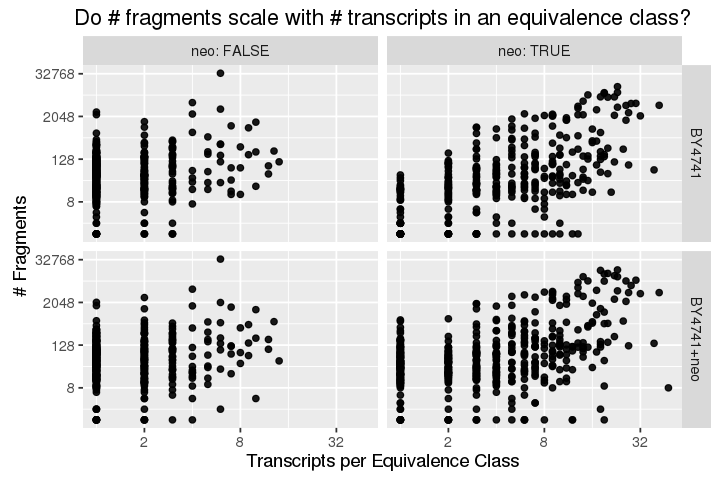

In [15]:
options(repr.plot.width = 6, repr.plot.height = 4)
p6 <- ggplot(eq_results %>% filter(kmer==15), 
            aes(x=as.numeric(tx.per.eq), y=as.numeric(frag.per.eq))) +
    geom_point(alpha=0.9) +
    scale_y_continuous(trans="log2") +
    scale_x_continuous(trans="log2") +
    ylab("# Fragments") +
    xlab("Transcripts per Equivalence Class") +
    ggtitle("Do # fragments scale with # transcripts in an equivalence class?") +
    facet_grid(ezsample ~ neo, labeller = labeller(neo = label_both))
p6

# Figure 7: Relative quantification, TPM +neo / -neo

Seems to work pretty well. Most sig changes are increased # reads mapping to tRNAs on neochr

In [16]:
relative.quant = results %>% filter(kmer==15, grepl("tRNA",Name)) %>% group_by(Name) %>% do({
    s2.data = filter(.,sample=="S2")
    if (dim(s2.data)[1]>1) {
        s2.data = s2.data %>% filter(origin == "WT")
    }
    s3.data = filter(.,sample=="S3")
    if (dim(s3.data)[1]>1) {
        s3.data = s3.data %>% filter(origin == "WT")
    }
    Name = unique(.$Name)
    otherstuff = select(., AA, Isotype, origin, Name.original, seqid, start ,end, strand, type, mature.trna, ezseqid) %>%
        distinct(.keep_all = T)
    if (s2.data$TPM >= 1) {
        relative.tpm = s3.data$TPM/s2.data$TPM
    } else {
        relative.tpm = s3.data$TPM
    }
    if (s2.data$NumReads >= 1) {
        relative.numreads = s3.data$NumReads/s2.data$NumReads
    } else {
        relative.numreads = s3.data$NumReads
    }
    
    o = data.frame(Name, relative.tpm, relative.numreads, otherstuff)
    return(o)
})

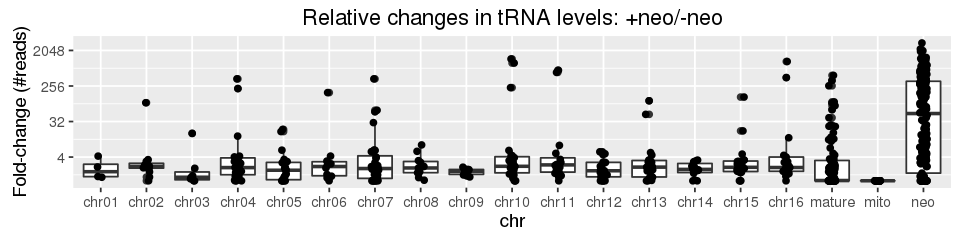

In [17]:
options(repr.plot.width = 8, repr.plot.height = 2)

p7 <- ggplot(relative.quant, aes(x = ezseqid, y = relative.numreads+1)) + 
    geom_boxplot() + geom_jitter(width = 0.2) + scale_y_continuous(trans="log2") +
    ggtitle("Relative changes in tRNA levels: +neo/-neo") + ylab("Fold-change (#reads)") +
    xlab("chr")
p7

# Conclusions

- k-mer index size does not dramatically affect quantification of CRAC-seq data, but there are differences in results
- k-mer index of 15 has the lowest rates of misquantification, so it will be used for subsequent analyses. *Misquantifications (and rates) can be computed as number of tRNAs on the neochr with an estimated abundance > 0 in strains that do not have the neochromosome (e.g. BY4741)*
- Misquantification rate is at least 20%
- Origins of misquantifications remain mysterious, but are at least partially explained by the number of equivalence classes a tRNA maps to. More classes is related to fewer unique sequences which is turn related to quantification problems
- Using only estimates of unique equivalence classes could help, but wouldn't solve the problem completely

# Way forward

I will explore whether we can use the ratio of +neo/-neo to obtain better estimates. Will do this for the tRNA-seq so that I can compare to triple-syn strain.